In [1]:
from glob import glob
import cv2
import numpy as np
from numpy.polynomial import polynomial as P
import matplotlib.pyplot as plt
import tifffile as tf

from scipy import ndimage, signal
from skimage import morphology

import os
import pandas as pd

In [2]:
buffx = 0
buffX = 1475
buffy = 200

src = '../raw/'
dst = '../proc/'

In [10]:
time = '4pm'
rep = 7

meta = pd.read_csv('../reference/reference_positions_{}_rep{}.csv'.format(time, rep))
meta.head()

,numidx,peaks_0,peaks_1,peaks_2,peaks_3,peaks_4,tapes_0,tapes_1,tapes_2,tapes_3,...,coef0_0,coef0_1,coef0_2,coef0_3,coef0_4,coef1_0,coef1_1,coef1_2,coef1_3,coef1_4
0,1,609,1305,2071,2937,3770,890,977,978,1180,...,224.909,208.154375,190.235,183.072,189.759,-0.017661,-0.014411,0.001748,0.014864,0.009036
1,2,597,1291,2069,2931,3769,890,977,978,1180,...,227.745,200.906000,186.711,181.974,192.212,-0.017171,0.005466,0.004167,0.015038,0.008899
2,3,577,1296,2061,2927,3762,890,977,978,1180,...,236.140,189.641375,187.639,183.790,190.927,-0.011535,0.008313,0.003852,0.011888,0.011083
3,4,583,1296,2064,2930,3766,890,977,978,1174,...,232.565,189.641375,185.558,180.871,187.369,-0.011769,0.014634,0.003632,0.012464,0.010194
4,5,604,1297,2065,2925,3761,890,976,978,1176,...,218.414,201.373000,184.803,182.785,189.889,-0.017212,-0.003465,0.003809,0.014073,0.009635


In [14]:
adst = dst + 'anchory/' + time + '_rep{}/'.format(rep)
pdst = dst + 'prelim/' + time + '_rep{}/'.format(rep)

if not os.path.isdir(adst):
    os.mkdir(adst)
if not os.path.isdir(pdst):
    os.mkdir(pdst)

for i in range(5):
    for bar in [adst, pdst]:
        foo = bar + '/plant_{:02d}/'.format(i)
        if not os.path.isdir(foo):
            os.mkdir(foo)

In [15]:
idx = 122
foldername = time + ' Inc Rep ' + str(rep)
filename = glob(src + foldername + '/*({})*.JPG'.format(idx))[0]
print(filename)

raw = cv2.imread(filename)
rawstd = np.var(raw, axis=2, ddof=1)
rawmean = np.mean(raw, axis = 2)

graw = raw[:,:,1]
hsv = cv2.cvtColor(raw, cv2.COLOR_BGR2HSV)
h, s, v = cv2.split(hsv)

../raw/4pm Inc Rep 7/4pm Inc Rep 7 (122).JPG


# Remove most of the background and foreground

In [16]:
stdmask = (rawstd > 60) | (rawmean > 210)

hmask = ((h < 40) & (h > 0)) & (v > 60) & stdmask

img = raw.copy()
for i in range(3):
    img[:,:,i] *= hmask

# Find the y-coord for the sticks

Peaks (pre):	 [ 740 1419 2179 3024 3719 4660]
Peaks (post):	 [ 740 1419 2179 3024 3719 4660]


NameError: name 'coef' is not defined

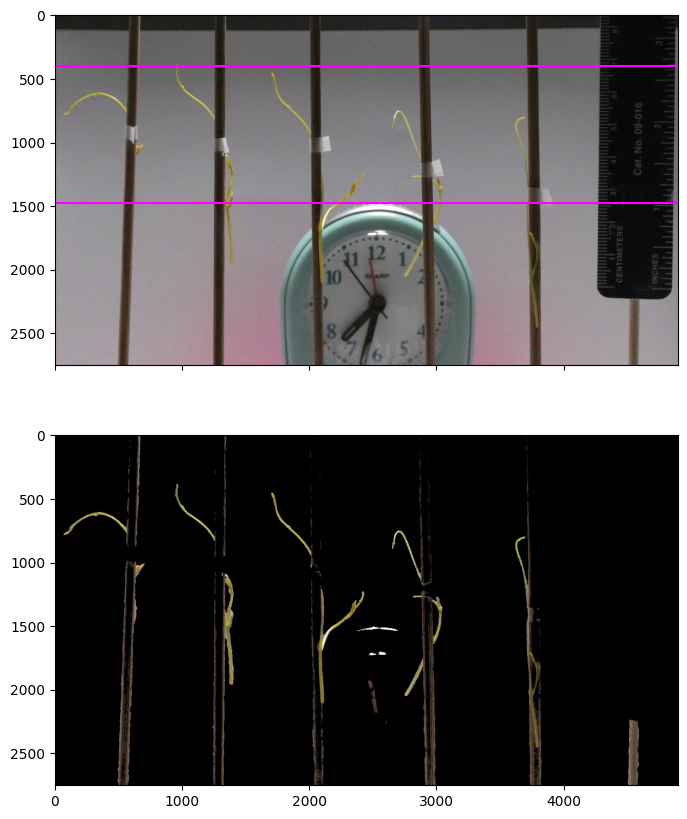

In [17]:
fig, ax = plt.subplots(2,1,figsize=(12,10), sharex=True, sharey=True)
ax[0].imshow(raw[:, :, ::-1])
ax[1].imshow(img[:, :, ::-1])
for i in range(len(ax)):
    for j in range(len(coef)):
        ax[i].plot([lines[j,tapes[j]]-100, lines[j,tapes[j]]+100], [buffx+tapes[j], buffx+tapes[j]], c='yellow', lw=3)
        ax[i].plot(lines[j], xvals, c='red', lw=2)
        ax[i].axvline(peaks[j], c='limegreen', ls='--', lw=1)

fig.tight_layout()

# Separate the sticks and cuscuta

In [24]:
plants = [ np.s_[buffx:tapes[0]+buffx, 0:peaks[1]-buffz] ]

for i in range(1,len(tapes)):
    plants.append(np.s_[buffx:tapes[i]+buffx, peaks[i-1]+buffz:peaks[i+1]-buffz])
plants

[(slice(0, 938, None), slice(0, 1369, None)),
 (slice(0, 1019, None), slice(790, 2129, None)),
 (slice(0, 962, None), slice(1469, 2974, None)),
 (slice(0, 732, None), slice(2229, 3669, None)),
 (slice(0, 1018, None), slice(3074, 4610, None))]

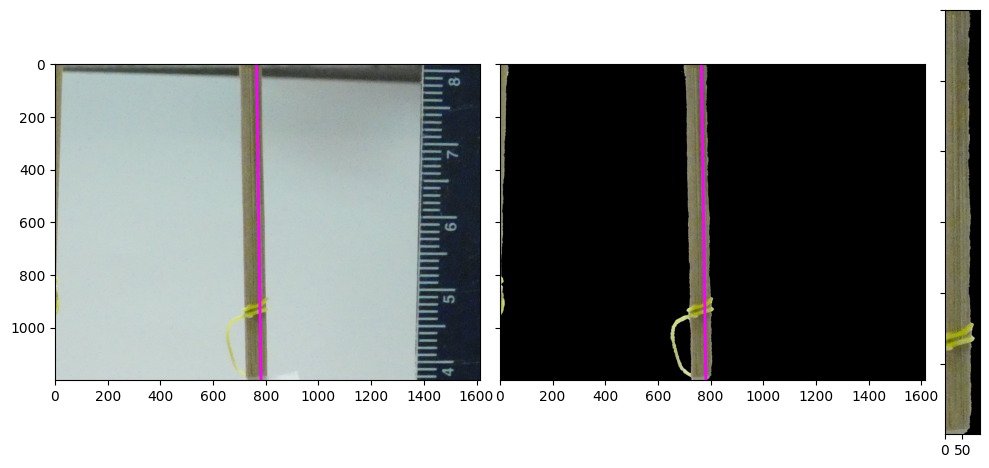

In [74]:
pidx = 4
anchory = peaks[pidx]-plants[pidx][1].start
xlen = xvals[ plants[pidx][0] ] - plants[pidx][0].start
line = lines[ pidx, plants[pidx][0] ] - plants[pidx][1].start
patch = img[plants[pidx]][:,:,::-1]

skewer = np.zeros((len(line), 2*buffz, 3), dtype=np.uint8)
for i in range(len(skewer)):
    foo = int(line[i])
    skewer[i] = patch[i, foo-buffz:foo+buffz, :]

fig, ax = plt.subplots(1,3,figsize=(10,5), sharex=False, sharey=True, width_ratios=[12,12,1])
ax = np.atleast_1d(ax).ravel()

ax[0].imshow(raw[plants[pidx]][:,:,::-1]);
ax[1].imshow(patch);
ax[2].imshow(skewer)

for i in range(2):
    ax[i].plot(line, xlen, color='magenta', lw=2);

fig.tight_layout()

# Only keep the large chunks that are close to the central axis

In [75]:
median = ndimage.median_filter(patch[:,:,1], size=11)

skewer = np.zeros((len(line), 2*buffz))
for i in range(len(skewer)):
    foo = int(line[i])
    skewer[i] = patch[i, foo-buffz:foo+buffz, 1]
    
bar = np.sum(skewer > 0)/skewer.size
#bar = np.sqrt(bar)
print(bar)
if len(skewer[skewer > 0]) < 10:
    bar = mind
else:
    foo = np.quantile(skewer[skewer > mind], 0.8)
    print(foo)
    foo = np.min([115, foo])
    bar = np.floor(mind + bar*(foo - mind))
print(bar)
#bar = 80
median[median < bar] = 0
median[median > 0] = 1
#median = ndimage.binary_dilation(median, iterations=5)

labels,num = ndimage.label(median, structure=struc1)

0.6892994161801501
127.0
94.0


In [76]:
minsize = 100
comp_size = np.zeros(num, dtype=int)
feret = np.zeros((num,2))
touch = np.zeros((num,4))
dtouch = np.zeros(num, dtype=int)

# Compute geometrical shape descriptors for each connected component
# We will later drop those that are either:
# - Too oblong
# - Far away from the central axis
# - Too small
# - Too narrow

for i in range(num):
    box = median.copy()
    box[labels != i+1] = 0

    coords = np.asarray(np.nonzero(box))
    feret[i] = np.max(coords, axis=1) - np.min(coords, axis=1) + np.array([1,1])
    comp_size[i] = len(coords[1])
    
    foo = np.abs(line[coords[0]] - coords[1])
    
    bar = np.argmin(foo)
    dtouch[i] = foo[bar]
    touch[i,:2] = coords[:,bar]
    
f_ratio = np.divide(*np.sort(feret, axis=1).T) 

In [77]:
if False:
    df = pd.DataFrame(np.column_stack((comp_size, feret, dtouch)), dtype=int,
                      columns = ['size', 'feret_x', 'feret_y', 'd_min'])
    df['ratio'] = f_ratio
    df.sort_values(by='size', ascending=False)

In [78]:
comp_mask = ( (feret[:,1] > 30) | (f_ratio > 0.35) | (dtouch < 5) ) & (comp_size > 100) & (dtouch < 75) & (f_ratio > 0.075)

size_mask = comp_size/np.sum(comp_size[comp_mask]) > 0.06

mask = comp_mask & size_mask

box = np.zeros_like(labels).astype(bool)
comp_labels = np.nonzero(mask)[0]

for i in comp_labels:
    box[labels == i+1] = True

print(comp_size[comp_mask])
print(comp_size[comp_mask]/np.sum(comp_size[comp_mask]))

[98319]
[1.]


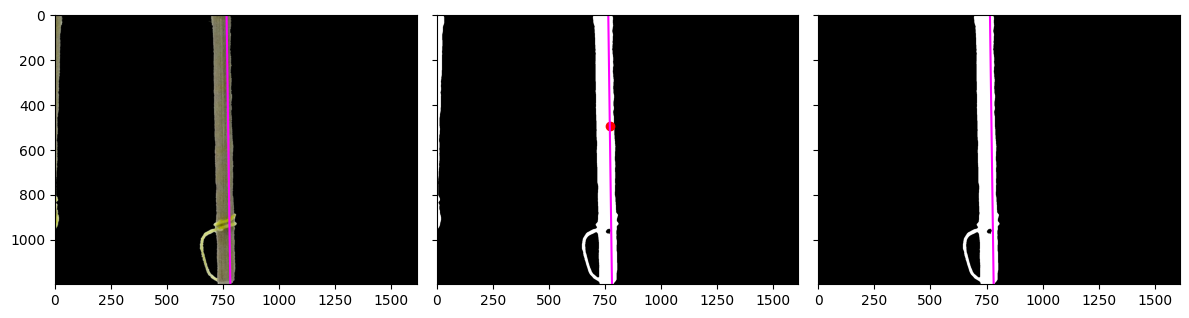

In [79]:
fig, ax = plt.subplots(1,3,figsize=(12,10), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel()

ax[0].imshow(patch, origin='lower');

ax[1].imshow(median, cmap='Greys_r', vmax=1)
ax[1].scatter(touch[mask, 1], touch[mask, 0], c='red')
#ax[1].scatter(touch[~mask, 1], touch[~mask, 0], c='blue', marker='^')
ax[2].imshow(box, cmap='Greys_r', vmin=0, vmax=1)

for i in range(len(ax)):
    ax[i].plot(line, xlen, c='magenta')

fig.tight_layout();

# Skeletonize and reduce box size

In [80]:
skel = morphology.thin(box)
ceros = np.zeros(4, dtype=int)
cero = np.nonzero(np.any(box, axis = 1))[0][np.asarray([0,-1])]
ceros[:2] = cero
print(ceros)
print(box.shape, skel.shape, erode[pidx].shape, peaks[pidx], anchory, buffy)
print(anchory-buffy, anchory+buffy)

comb = box[ceros[0]:ceros[1], : ].copy().astype(np.uint8)
comb[:, anchory-buffy:anchory+buffy] += 2*(erode[pidx][ceros[0]:ceros[1], :]).astype(np.uint8)

cero = np.nonzero(np.any(comb != 0, axis = 0))[0][np.asarray([0,-1])]
ceros[2:] = cero
ss = np.s_[ceros[0]:ceros[1], ceros[2]:ceros[3]]
print(ss)

comb = comb[:, ceros[2]:ceros[3]]*2
comb[comb == 4] = 1
comb[comb == 2] = 3
comb[comb == 6] = 4
#comb[comb == 1] = 2 

comb[ skel[ss] ] += 2

[   0 1198    0    0]
(1199, 1613) (1199, 1613) (1475, 400) 4008 775 200
575 975
(slice(0, 1198, None), slice(575, 974, None))


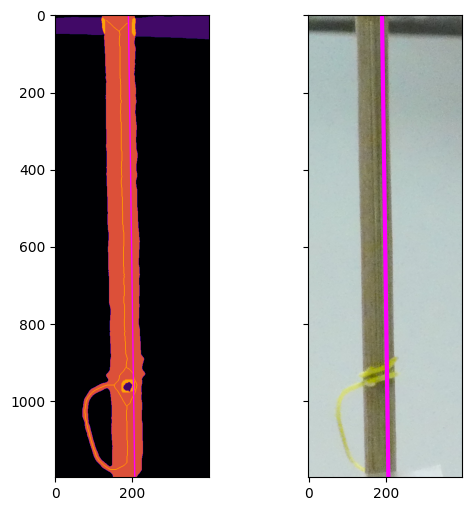

In [81]:
fig, ax = plt.subplots(1,2,figsize=(6,6), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel()

ax[0].imshow(comb, cmap='inferno', vmin=0, zorder = 2);
#ax[0].axvline(anchory-ceros[2], color='lime', lw=1, ls='--');
ax[0].plot(line[np.arange(ceros[0],ceros[1])] - ceros[2], range(ceros[1]-ceros[0]), color='magenta', lw=1);

ax[1].imshow(raw[plants[pidx]][ss][:,:,::-1], cmap='inferno', vmin=0, zorder = 2);
#ax[1].axvline(anchory-ceros[2], color='lime', lw=3, ls='--');
ax[1].plot(line[np.arange(ceros[0],ceros[1])] - ceros[2], range(ceros[1]-ceros[0]) , color='magenta', lw=3);

In [18]:
filename = pdst + 'plant_{:02d}/{}_rep{:02d}_{:04d}'.format(pidx, time, rep, numidx)
print(filename)

tf.imwrite(filename + '.tif', comb*40, photometric='minisblack')

../proc/prelim/9am_rep3/plant_04/9am_rep03_0772


In [31]:
plants

[(slice(150, 834, None), slice(0, 1436, None)),
 (slice(150, 916, None), slice(877, 2206, None)),
 (slice(150, 986, None), slice(1536, 2985, None)),
 (slice(150, 1179, None), slice(2306, 3779, None)),
 (slice(150, 601, None), slice(3085, 4460, None))]

In [54]:
meta = [
        tapes[pidx],
        peaks[pidx],
        buffx, buffy,
        plants[pidx][0].start, plants[pidx][0].stop, plants[pidx][1].start, plants[pidx][1].stop,
        *ceros,
        anchory
]

print(len(meta))
meta

13


[658, 3829, 0, 200, 0, 938, 2997, 4329, 257, 937, 645, 762, 714]

In [55]:
df = pd.DataFrame(meta, dtype=int).T
df[13] = coef[pidx, 0]
df[14] = coef[pidx, 1]
print(df.shape)

(1, 15)


In [ ]:
filename = adst + 'plant_{:02d}/{}_rep{:02d}_{:04d}'.format(pidx, time, rep, numidx)
print(filename)
df.to_csv(filename + '.csv', index=False, header=False)